In [4]:
# import all functions in Utils
import sys
sys.path.insert(1, '../')

from Utils import *

# Create folders to save the results
output = 'output'
folder_img = 'IMG'

create_dir(output)
create_dir(folder_img)


n_shots = 8192

The directory output  already exists
The directory IMG does not exist and will be created


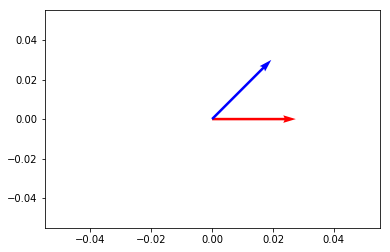

                     ┌─────────────────┐       ░               ░       ░    
x\_train_0: |0>──────┤ Initialize(1,0) ├───────░───────X───────░───────░────
               ┌─────┴─────────────────┴─────┐ ░       │       ░       ░    
 x\_test_0: |0>┤ Initialize(0.70711,0.70711) ├─░───────X───────░───────░────
               └─────────────────────────────┘ ░ ┌───┐ │ ┌───┐ ░ ┌───┐ ░ ┌─┐
y\_test}_0: |0>────────────────────────────────░─┤ H ├─■─┤ H ├─░─┤ X ├─░─┤M├
                     ┌─────────────────┐       ░ └───┘   └───┘ ░ └─┬─┘ ░ └╥┘
y\_train_0: |0>──────┤ Initialize(0,1) ├───────░───────────────░───■───░──╫─
                     └─────────────────┘       ░               ░       ░  ║ 
       c0_0: 0 ═══════════════════════════════════════════════════════════╩═
                                                                            


In [3]:
''' State Preparation'''
## ++++++++++++++++++++++++++++++++++ ##

# Training points
x_train = [4, 0 ]; x_train = normalize_custom(x_train)
y_train = [0, 1 ]

# Test point
x_test = [2, 2]; x_test = normalize_custom( x_test )

# Visualization of the two vectors
V = np.array([ x_train, x_test])
origin = [0], [0] # origin point
plt.quiver(*origin, V[:,0], V[:,1], color=['r','b'], scale = 4)
plt.show()


# Quantum Circuit for Cosine-distance classifier
c = ClassicalRegister(1)
ancilla = QuantumRegister( 1 , 'y\_test}')

x_tr = QuantumRegister(1, 'x\_train')
x_ts = QuantumRegister(1, 'x\_test')
y_tr = QuantumRegister(1, 'y\_train')

qc = QuantumCircuit( x_tr, x_ts, ancilla, y_tr, c)

x_tr = x_tr[0]
y_tr = y_tr[0]
x_ts = x_ts[0]

qc.initialize(x_train, [ x_tr ])
qc.initialize(x_test, [ x_ts ])
qc.initialize(y_train, [ y_tr ])
qc.barrier()

qc.h( ancilla )
qc.cswap( ancilla, x_ts, x_tr )
qc.h(ancilla)
qc.barrier()

qc.cx( y_tr, ancilla)
qc.barrier()

qc.measure(ancilla, c[0])
print(qc)


In [ ]:

# diagram = qc.draw(output="mpl")
# diagram.show()
# diagram.savefig(folder_img + "/cosine_classifier.jpeg",
#                 format="jpeg")


# QASM Simulation
sim_backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, sim_backend, shots=1000)
results = job.result()
answer = results.get_counts(qc)

if len(answer) == 1:
    quantum_prob = 1
else:
    quantum_prob = answer['0']/(answer['0'] + answer['1'] )

answer_sim_p0 = quantum_prob
answer_sim_p1 = 1 - quantum_prob

print(answer_sim_p0, answer_sim_p1)


In [ ]:
## Running on real device

# ****** ---------------------------------------------******* #
job = execute(qc, backend, shots=8192)
results = job.result()
answer = results.get_counts(qc)
print(answer)

if len(answer) == 1:
    quantum_prob = 1
else:
    quantum_prob = answer['0']/(answer['0'] + answer['1'] )

answer_rl_p0 = quantum_prob
answer_rl_p1 = 1- quantum_prob


N = 2
p0 = [ answer_sim_p0, answer_rl_p0]
p1 = [ answer_sim_p1, answer_rl_p1]
#
fig, ax = plt.subplots()
#
ind = np.arange(N)  # the x locations for the groups
width = 0.35  # the width of the bars
pl1 = ax.bar(ind, p0, width, bottom=0)
pl2 = ax.bar(ind + width, p1, width, bottom=0)
#
ax.set_title('Test point classifications')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('QASM', 'REAL DEVICE'), rotation = 45)
#
ax.legend((pl1[0], pl2[0]), ('P(y=0)', 'P(y=1)'))
ax.autoscale_view()
#
plt.savefig(folder_img + '/qasm_vs_real.png',
                format="jpeg",  bbox_inches="tight")
plt.show()